In [92]:
## Load Python libraries

import datetime as dt
import pandas as pd

from wmfdata import hive, mariadb

In [2]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

**POTENTIAL FIXME:** Install Mikhail's ggplot theme and try out using that for the graphs.

In [3]:
%%R
library(ggplot2);
library(data.table);

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: data.table 1.11.8  Latest news: r-datatable.com

  warnings.warn(x, RRuntimeWarning)


In [80]:
## Some configuration:
## The wikis we're grabbing data for, start and end dates, and the data lake snapshot we'll use

wikis = ['enwiki', 'itwiki', 'frwiki', 'eswiki']

## FIXME: dates can be calculated relative to the snapshot date, just subtract here and there.

## Per discussions with the AHT team, let's limit this to the past five years for now.
start_date = "2014-01-01"
end_date = "2019-01-01"

## This is the end date used in queries where there is a right-truncation (e.g. users not reblocked
## within 28 days)
end_date_truncated = "2018-12-01"

snapshot = '2018-12'

## A. Number of sitewide blocks

The first measurement is the number of sitewide blocks per month.

**POTENTIAL FIXME:** This can be rewritten to select all block-related events, then use the `lag` function to get the block/unblock status of the previous event, and use that to filter out all reblock events (both current and previous event is a block). That removes the need for the join. It'll require a sub-query to add the lagged column, but the surrounding query should be quite readable.

In [59]:
sitewide_query = '''
SELECT h1.wiki_db,
       DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h1
LEFT JOIN (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h2
ON (h1.wiki_db = h2.wiki_db
    AND h1.user_id = h2.user_id
    AND h1.start_timestamp = h2.end_timestamp)
WHERE h2.start_timestamp IS NULL
GROUP BY h1.wiki_db, DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_blocks = hive.run(sitewide_query.format(
    snapshot = snapshot,
    start_date = start_date,
    end_date = end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [60]:
sitewide_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2014-01-01,6343
1,enwiki,2014-02-01,6096
2,enwiki,2014-03-01,7223
3,enwiki,2014-04-01,6707
4,enwiki,2014-05-01,7375


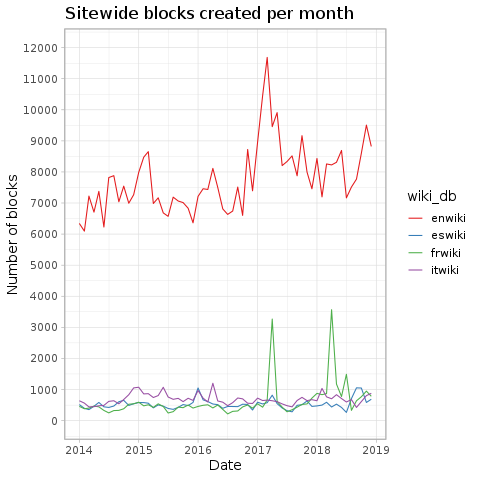

In [64]:
%%R -i sitewide_blocks

sitewide_blocks = data.table(sitewide_blocks);
sitewide_blocks[, log_month := as.Date(log_month)];

sitewide_block_graph = ggplot(sitewide_blocks, aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 12000), breaks = c(0:12)*1000) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide blocks created per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_blocks_per_month.png",
       plot = sitewide_block_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_block_graph;

## B. Number of non-indefinite sitewide blocks

This is similar to the previous statistic, but limits it to sitewide blocks that have an expiry timestamp set. To get that, we make a small modification to the previous query. From examining the data, indefinite blocks have `end_timestamp` set to `NULL`, so I'll exclude those.

In [65]:
sitewide_limited_query = '''
SELECT h1.wiki_db,
       DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h1
LEFT JOIN (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h2
ON (h1.wiki_db = h2.wiki_db
    AND h1.user_id = h2.user_id
    AND h1.start_timestamp = h2.end_timestamp)
WHERE h1.caused_by_block_expiration != "indefinite"
AND h2.start_timestamp IS NULL
GROUP BY h1.wiki_db, DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_limited_blocks = hive.run(sitewide_limited_query.format(
    snapshot = snapshot,
    start_date = start_date,
    end_date = end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [66]:
sitewide_limited_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2014-01-01,398
1,enwiki,2014-02-01,359
2,enwiki,2014-03-01,406
3,enwiki,2014-04-01,349
4,enwiki,2014-05-01,361


/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


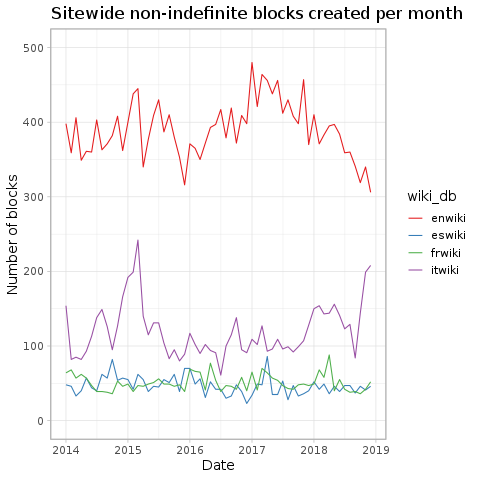

In [67]:
%%R -i sitewide_limited_blocks

sitewide_limited_blocks = data.table(sitewide_limited_blocks);
sitewide_limited_blocks[, log_month := as.Date(log_month)];

sitewide_limited_block_graph = ggplot(sitewide_limited_blocks,
                                      aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 500), breaks = c(0:5)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide non-indefinite blocks created per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_non-indefinite_blocks_per_month.png",
       plot = sitewide_limited_block_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_limited_block_graph;

## D. Number of sitewide blocks that expire

This is also similar to the previous queries, but is focused on blocks that reach their expiry timestamp. In this case, it looks like I can identify these by `caused_by_block_expiry` being set to a timestamp (meaning it is not `NULL` nor `indefinite`). One thing to note is that in these events, it's the `end_timestamp` that is the time of when the block expired, while `start_timestamp` is when it was set. So we need to look for matches between the end timestamp and the time of block expiry, those are the events where the block expired without any further action being taken. If a user has their block altered before it expired, the end timestamp is different (typically sooner than) the timestamp set in `caused_by_block_expiration`.

In [71]:
expired_blocks_query = '''
SELECT wiki_db,
       DATE_FORMAT(start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM wmf.mediawiki_user_history
WHERE snapshot = "{snapshot}"
AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
AND wiki_db IN ({wikis})
AND caused_by_block_expiration IS NOT NULL
AND caused_by_block_expiration != "indefinite"
AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
     = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_expired_blocks = hive.run(expired_blocks_query.format(
    snapshot = snapshot,
    start_date = start_date,
    end_date = end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [69]:
sitewide_expired_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2016-09-01,377
1,enwiki,2017-04-01,381
2,frwiki,2015-07-01,66
3,itwiki,2014-05-01,74
4,enwiki,2014-02-01,330


/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


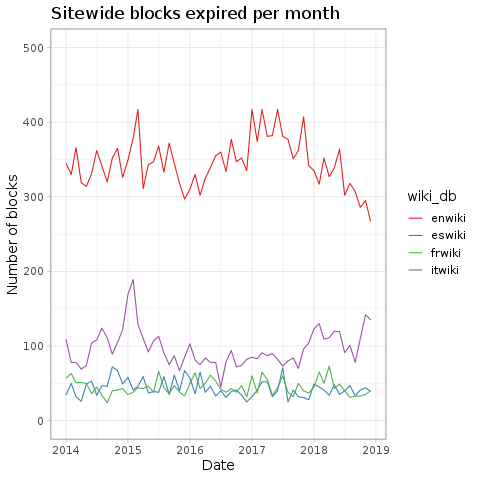

In [70]:
%%R -i sitewide_expired_blocks

sitewide_expired_blocks = data.table(sitewide_expired_blocks);
sitewide_expired_blocks[, log_month := as.Date(log_month)];

sitewide_expired_blocks_graph = ggplot(sitewide_expired_blocks,
                                      aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 500), breaks = c(0:5)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide blocks expired per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_expired_blocks_per_month.png",
       plot = sitewide_expired_blocks_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_expired_blocks_graph;

## F. Expired blocks that don't get reblocked

Number of sitewide blocks for users/IPs where the block has an expiry timestamp within the month of interest, and where the user/IP does not receive another sitewide block within 28 days after block expiry.

So this builds on D. I'd prefer to not have to self-join again. Is there a window or something? Yes, there is the `lag` function, WOOHOO!

In [81]:
## How many days need to lapse before the user can be blocked again

days_until_next_block = 28

expired_not_reblocked_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id,
    start_timestamp, end_timestamp,
    caused_by_block_expiration,
    COALESCE(inferred_from, "block") AS block_status,
    COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
        "block") AS next_block_status,
    LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
         AS next_block_end_timestamp
    FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
      AND wiki_db IN ({wikis})
      AND caused_by_event_type = 'alterblocks') AS block_events
WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
AND caused_by_block_expiration IS NOT NULL
AND caused_by_block_expiration != "indefinite"
AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
     = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
AND next_block_status = "unblock"
AND (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
     unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*{ndays})
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_not_reblocked = hive.run(expired_not_reblocked_query.format(
    snapshot = snapshot,
    start_date = start_date,
    end_date = end_date_truncated,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [82]:
sitewide_not_reblocked.head()

,wiki_db,log_month,num_blocks
0,enwiki,2014-01-01,97
1,enwiki,2014-02-01,86
2,enwiki,2014-03-01,91
3,enwiki,2014-04-01,65
4,enwiki,2014-05-01,71


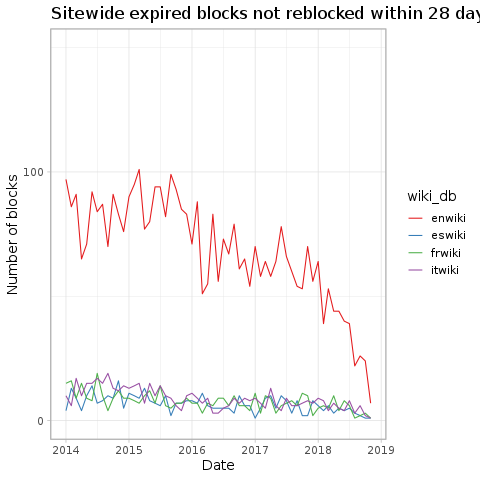

In [85]:
%%R -i sitewide_not_reblocked

sitewide_not_reblocked = data.table(sitewide_not_reblocked);
sitewide_not_reblocked[, log_month := as.Date(log_month)];

sitewide_not_reblocked_graph = ggplot(sitewide_not_reblocked,
                                      aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 150), breaks = c(0:2)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide expired blocks not reblocked within 28 days',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_not_reblocked_28days_per_month.png",
       plot = sitewide_not_reblocked_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_not_reblocked_graph;

## G. Same as F, but makes >1 non-reverted edit

They have the same 28 day period to make one or more edits. So, we join with the edit history table, and accumulate edits.

It might be tempting to not calculate this, based on the low number of users who do not get reblocked within 28 days. But what we're curious about is the proportion of expired blocks that meet this (and the previous) condition. Both F and G are used in further calculations, with proportions relative to what we measured in section D.

**FIXME:** The `where` clause on `end_timestamp` that's now in the outermost query can be moved into the `block_events` query to limit data gathering to only block events with an end timestamp in the period of interest. Not sure if that'll speed things up massively, but it's probably worth doing. We can also add a check for `DATE(event_timestamp) >= {start_date}` to the `revisions` query, as older revisions are not needed.

In [87]:
expired_nonreverted_edit_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id, end_timestamp, count(*) AS num_edits
    FROM (SELECT block_events.wiki_db,
          block_events.user_id,
          block_events.end_timestamp
        FROM (SELECT wiki_db,
                     user_id,
                     end_timestamp
            FROM (SELECT wiki_db, user_id,
                start_timestamp, end_timestamp,
                caused_by_block_expiration,
                COALESCE(inferred_from, "block") AS block_status,
                COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id
                    ORDER BY start_timestamp), "block") AS next_block_status,
                LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
                     AS next_block_end_timestamp
                FROM wmf.mediawiki_user_history
                WHERE snapshot = "{snapshot}"
                  AND wiki_db IN ({wikis})
                  AND caused_by_event_type = 'alterblocks') AS block_events
            WHERE caused_by_block_expiration IS NOT NULL
            AND caused_by_block_expiration != "indefinite"
            AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
                 = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
            AND next_block_status = "unblock"
            AND (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
                 unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*28)
            ) AS block_events
        JOIN (SELECT wiki_db, event_user_id, event_timestamp, event_entity
              FROM wmf.mediawiki_history
              WHERE snapshot = "{snapshot}"
              AND wiki_db IN ({wikis})
              AND event_entity = "revision"
              AND event_type = "create"
              AND (revision_is_identity_reverted = FALSE
                   OR revision_seconds_to_identity_revert > 60*60*48)
            ) AS revisions
        ON (block_events.wiki_db = revisions.wiki_db
            AND block_events.user_id = revisions.event_user_id)
        WHERE revisions.event_timestamp > block_events.end_timestamp
          AND unix_timestamp(revisions.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") <
              (unix_timestamp(block_events.end_timestamp, "yyyy-MM-dd hh:mm:ss.0") +
               60*60*24*{ndays})
    ) AS post_block_edits
    GROUP BY wiki_db, user_id, end_timestamp
    HAVING count(*) > 0
) AS wiki_user_edits
WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_nonreverted_editors = hive.run(expired_nonreverted_edit_query.format(
    snapshot = snapshot,
    start_date = start_date,
    end_date = end_date_truncated,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [88]:
sitewide_nonreverted_editors.head()

,wiki_db,log_month,num_blocks
0,enwiki,2014-01-01,75
1,enwiki,2014-02-01,63
2,enwiki,2014-03-01,71
3,enwiki,2014-04-01,46
4,enwiki,2014-05-01,54


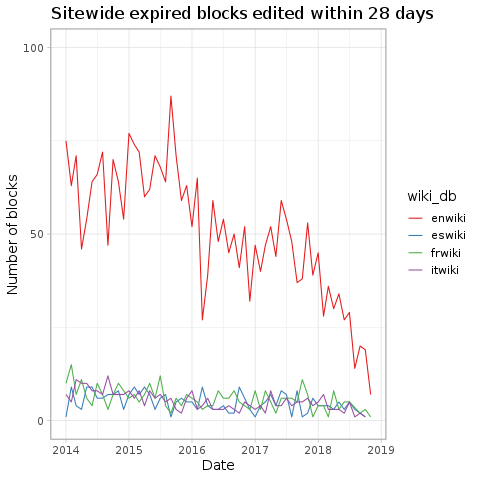

In [90]:
%%R -i sitewide_nonreverted_editors

sitewide_nonreverted_editors = data.table(sitewide_nonreverted_editors);
sitewide_nonreverted_editors[, log_month := as.Date(log_month)];

sitewide_nonreverted_editors_graph = ggplot(sitewide_nonreverted_editors,
                                      aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 100), breaks = c(0:2)*50) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide expired blocks edited within 28 days',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_nonreverted_editors_28days_per_month.png",
       plot = sitewide_nonreverted_editors_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_nonreverted_editors_graph;

# Measurements

Since we now have measurements D, F, and G calculated, we can use those to calculate proportion of expired blocks that were not reblocked, and proportion of expired blocks that made constructive edits.

## Proportion of expired blocks not reblocked

In [97]:
## Measure: Proportion of F in D

measurement_f = pd.merge(
    sitewide_expired_blocks.rename(columns={'num_blocks':'num_expired_blocks'}),
    sitewide_not_reblocked.rename(columns={'num_blocks':'num_non_reblocked'}),
    on=['wiki_db', 'log_month'])
measurement_f['prop'] = (100 *
                         measurement_f['num_non_reblocked'] / measurement_f['num_expired_blocks'])

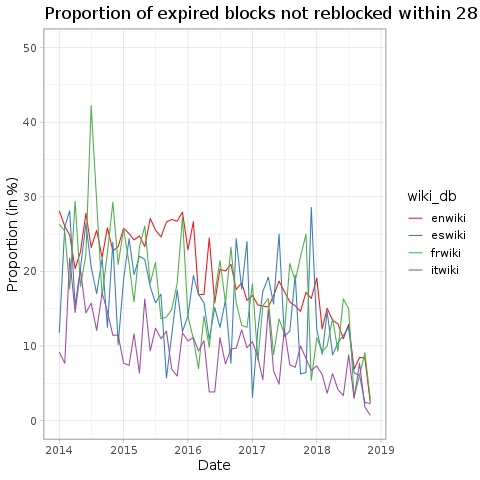

In [109]:
%%R -i measurement_f

measurement_f = data.table(measurement_f);
measurement_f[, log_month := as.Date(log_month)];

measurement_f_graph = ggplot(measurement_f,
                             aes(x=log_month, y=prop, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 50), breaks = c(0:5)*10) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Proportion of expired blocks not reblocked within 28 days',
     x = 'Date',
     y = 'Proportion (in %)') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/proportion_sitewide_blocks_not_reblocked.png",
       plot = measurement_f_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
measurement_f_graph;

## Proportion of expired blocks making constructive edits

In [104]:
## Measure: Proportion of G in D

measurement_g = pd.merge(
    sitewide_expired_blocks.rename(columns={'num_blocks':'num_expired_blocks'}),
    sitewide_nonreverted_editors.rename(columns={'num_blocks':'num_non_reverted'}),
    on=['wiki_db', 'log_month'])
measurement_g['prop'] = (100 *
                         measurement_g['num_non_reverted'] / measurement_g['num_expired_blocks'])

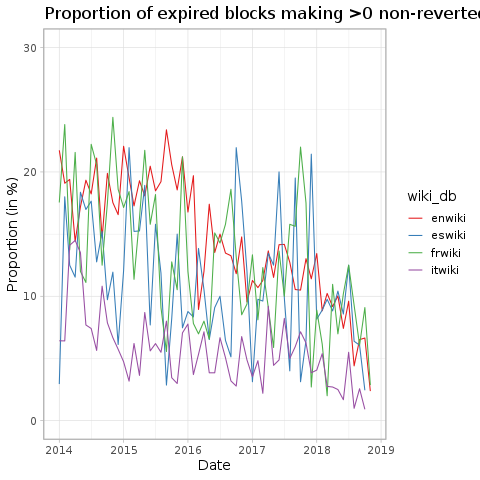

In [108]:
%%R -i measurement_g

measurement_g = data.table(measurement_g);
measurement_g[, log_month := as.Date(log_month)];

measurement_g_graph = ggplot(measurement_g,
                             aes(x=log_month, y=prop, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 30), breaks = c(0:4)*10) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Proportion of expired blocks making >0 non-reverted edits within 28 days',
     x = 'Date',
     y = 'Proportion (in %)') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/proportion_sitewide_blocks_non_reverted.png",
       plot = measurement_g_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
measurement_g_graph;